# Finance Time Series 데이터 프로젝트

### 프로젝트 개요

>암호화폐(ETH, 이더리움) 시계열 데이터를 바탕으로 시계열 특징을 추출하고,  
>특정 시점의 가격 상승 여부를 분류하는 모델을 학습 및 평가한다.

<br>

### 프로젝트 목표

>모멘텀 신호, 극값 탐지, 추세 방향성 판별, t-value 기반 회귀 분석,  
>기술적 지표 기반 분류 모델 학습 및 해석

<br>

### 최종 모델 선택

>개별 분류 모델(RandomForest, XGBoost, LightGBM)을 적용해보았으나, 하이퍼파라미터 튜닝에도 불구하고 성능 상의 한계을 확인하였다. 하나의 모델만으로는 복잡한 패턴을 충분히 반영하기 어렵다고 판단하였다.

>이에 따라 다양한 모델의 예측 결과를 통합해 성능을 향상시키기 위한 스태킹 앙상블 모델(Ensemble Stacking)을 도입하였다.
>
>Base model: &nbsp;RandomForest, XGBoost, LightGBM  
>Meta model: &nbsp;Logistic Regression.

>최적의 Threshold까지 적용한 결과, 성능이 유의미하게 향상된 것을 확인하였다.
>
>- Accuracy: &nbsp;0.8010
>- Precision: &nbsp;0.5955
>- Recall: &nbsp;0.9636
>- AUC: &nbsp;0.9118
>
>최종적으로 스태킹 모델을 최종 분류 모델로 선정하였다.

<br>
<br>

## 1. 데이터 로드 및 초기 탐색

- 라이브러리 불러오기

In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

- ETH 분당 시계열 CSV 불러오기
- 2017-11~12 종가 시각화

<Axes: xlabel='time'>

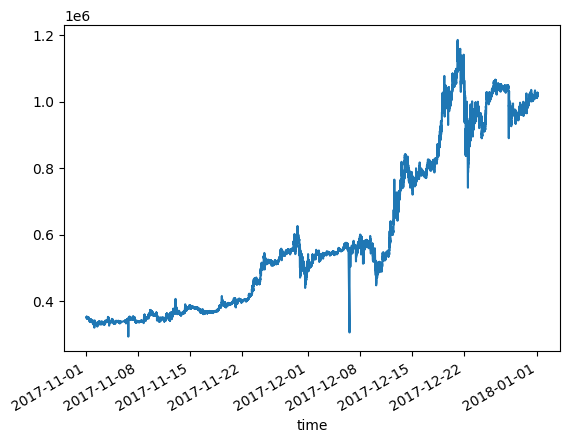

In [68]:
# 2017년 11~12월의 이더리움 종가(close) 시계열 시각화

DATA_PATH = '.'
# 시계열 인덱스 적용
#  - index_col=0, parse_dates=True
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

- 전체 기간 종가 시계열 흐름 시각화

<Axes: xlabel='time'>

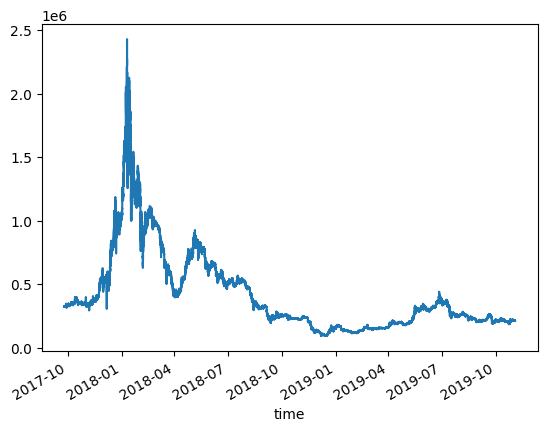

In [69]:
# 전체 데이터(2017~2019)의 종가 흐름 시각화

modify_data['close'].plot()

<br>

## 2. Data Labeling

### 2.1 &nbsp;Price Change Direction

- 10분 지연 모멘텀 신호 생성 (np.sign +1)

In [70]:
# 10분 지연된 모멘텀 신호 생성

window = 10
# np.sign(np.sign(...)+1): 결과를 +1, 0으로 제한
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
# 시계열 형태의 모멘텀 신호 저장
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

- 2017-11-21 모멘텀 신호 색상 시각화 (red/blue)

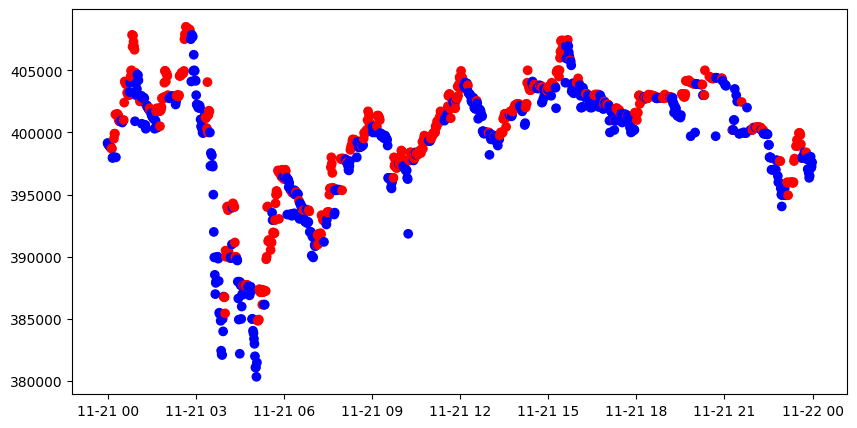

In [71]:
# 특정 날짜(2017-11-21)에 대한 모멘텀 색상 시각화
#  - 상승(+1): 빨간 점, 하락(0): 파란 점

sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

- 모멘텀 신호 상위 15개 확인

In [72]:
# 모멘텀 신호 초기 15개 시계열 확인

s_momentum_signal.head(15)

,close
time,
2017-09-25 03:00:00,NaN
2017-09-25 03:01:00,NaN
2017-09-25 03:02:00,NaN
2017-09-25 03:05:00,NaN
2017-09-25 03:06:00,NaN
2017-09-25 03:07:00,NaN
2017-09-25 03:10:00,NaN
2017-09-25 03:11:00,NaN
2017-09-25 03:12:00,NaN


<br>

### 2.2 &nbsp;Using Moving Average

- 이동평균 기반으로 신호 민감도 조정

In [73]:
# 이동 평균 기반 모멘텀 신호로 변경
#  - shift(window) → rolling(window).mean()으로 신호 민감도 조절
#  - 가격이 이동 평균보다 높으면 상승으로 간주

momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

- 수정된 신호 시각화 및 head 출력

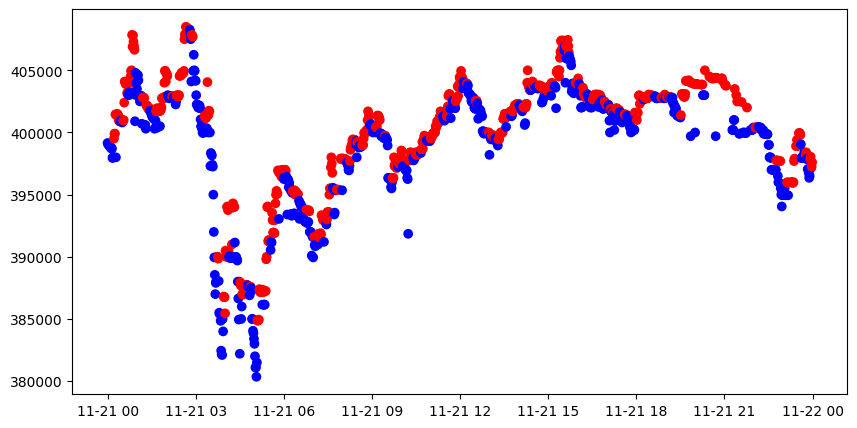

In [74]:
# 같은 방식으로 새로운 s_momentum_signal 시각화

sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [75]:
# 모멘텀 신호 초기 15개 시계열 확인

s_momentum_signal.head(15)

,close
time,
2017-09-25 03:00:00,NaN
2017-09-25 03:01:00,NaN
2017-09-25 03:02:00,NaN
2017-09-25 03:05:00,NaN
2017-09-25 03:06:00,NaN
2017-09-25 03:07:00,NaN
2017-09-25 03:10:00,NaN
2017-09-25 03:11:00,NaN
2017-09-25 03:12:00,NaN


<br>

### 2.3 &nbsp;Local Min-Max

- get_local_min_max() 함수 정의 (wait=3 조건)

In [76]:
# Local min / max 를 추출하기 위한 함수
#  - 현재 값이 이전보다 작거나 클 때 기록
#  - wait 파라미터로 연속 횟수 기준 설정
#  - 리턴값: min/max의 시점과 값이 담긴 DataFrame

def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

- 극값 시각화 (전체 및 확대)

In [77]:
# 추출한 mins, maxes를
#  - 전체 그래프
#  - 부분 확대 그래프
# 에 파란 점(최솟값), 빨간 점(최댓값) 으로 시각화

mins, maxes = get_local_min_max(sub_data, wait=3)

(376546.5, 412585.0)

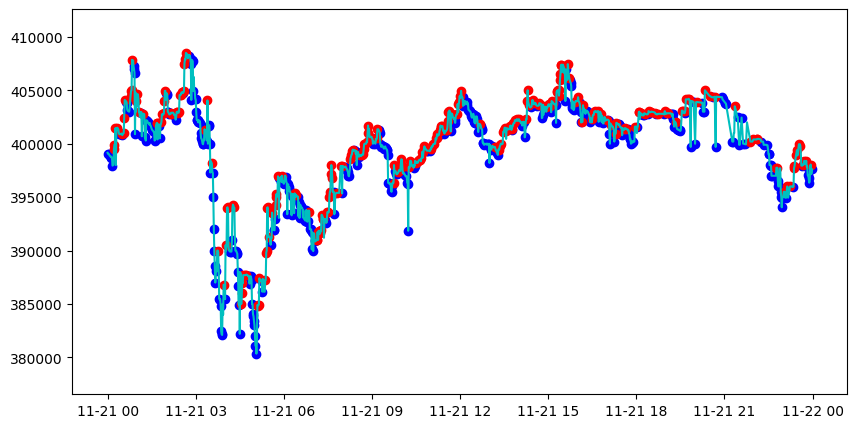

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

(376546.5, 412585.0)

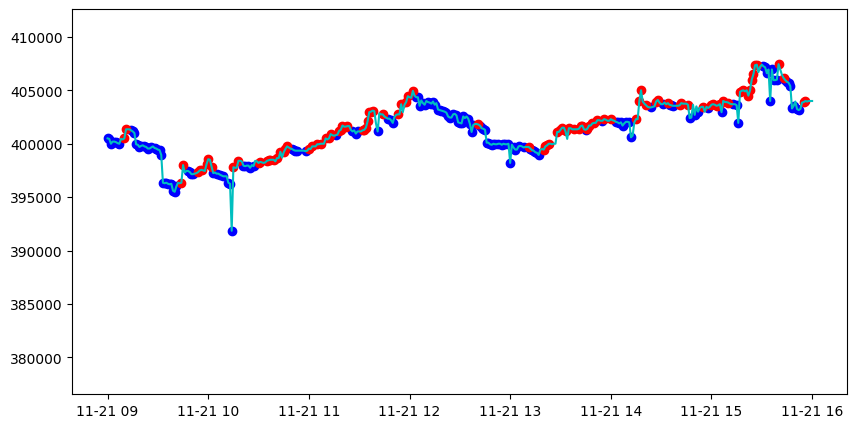

In [79]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

- 극솟값 출력

In [80]:
# 극솟값 테이블 출력

mins

,min_time,local_min
0,2017-11-21 00:01:00,399050
1,2017-11-21 00:03:00,399000
2,2017-11-21 00:04:00,398900
3,2017-11-21 00:05:00,398850
4,2017-11-21 00:06:00,398800
...,...,...
472,2017-11-21 23:48:00,397850
473,2017-11-21 23:50:00,397050
474,2017-11-21 23:52:00,396750
475,2017-11-21 23:53:00,396350


<br>

- 극값(min/max) 기반 trend 라벨링

In [81]:
# 로컬 extrema를 활용한 라벨링
#  - mins와 maxes를 시간 순 정렬하여 trend 방향 라벨링
#  - 다음 값이 크면 label=1, 작으면 label=0
#  - 라벨링 결과를 extrema_df에 저장

# 1. 극소/극대 포인트 합치기
extrema_df = pd.concat([
    mins.rename(columns={'min_time': 'time', 'local_min': 'value'}).assign(type='min'),
    maxes.rename(columns={'max_time': 'time', 'local_max': 'value'}).assign(type='max')
])

# 2. 시간 순으로 정렬
extrema_df = extrema_df.sort_values(by='time').reset_index(drop=True)

# 3. 각 구간의 변화 방향 라벨링
trend_labels = []
for i in range(len(extrema_df) - 1):
    current_val = extrema_df.loc[i, 'value']
    next_val = extrema_df.loc[i+1, 'value']
    label = 1 if next_val > current_val else 0
    trend_labels.append(label)

# 마지막 포인트는 라벨 없음 → NaN 또는 0 처리
trend_labels.append(0)

# 4. 최종 결과
extrema_df['label'] = trend_labels
print(extrema_df.head(15))


                  time   value type  label
0  2017-11-21 00:01:00  399050  min      0
1  2017-11-21 00:03:00  399000  min      0
2  2017-11-21 00:04:00  398900  min      0
3  2017-11-21 00:05:00  398850  min      0
4  2017-11-21 00:06:00  398800  min      0
5  2017-11-21 00:07:00  398800  min      0
6  2017-11-21 00:08:00  398700  min      0
7  2017-11-21 00:10:00  397950  min      1
8  2017-11-21 00:13:00  399500  max      1
9  2017-11-21 00:14:00  399900  max      1
10 2017-11-21 00:16:00  401450  max      0
11 2017-11-21 00:19:00  401350  max      1
12 2017-11-21 00:20:00  401500  max      0
13 2017-11-21 00:23:00  401000  min      0
14 2017-11-21 00:24:00  400900  min      0


<br>

### 2.4 &nbsp;Trend Scanning

- 선형 회귀 기반 t-value 계산 함수 정의

In [82]:
# 추세 강도 분석을 위한 t-value 계산
#  - statsmodels의 선형 회귀 분석으로 t-통계량 도출
#  - 특정 구간 길이 내에서 이동 시계열의 추세 유의성 측정

# 주어진 시계열 데이터 close에 대해 선형 회귀를 적용하여 기울기(추세)의 t-통계량을 반환하는 함수
#  - 해당 구간에 뚜렷한 추세가 존재하는지를 통계적으로 판단하기 위해 사용
#  - x: [1, 2, ..., n]의 순차적 숫자를 독립 변수로 설정 (시간 흐름)
#  - OLS(close, x): 선형 회귀 모델
#  - tvalues[1]: 기울기(추세)의 유의성 판단에 사용되는 t-value

# 선형 회귀 기반 t-value 반환 함수 정의
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

- 탐색 구간 및 최소 길이 설정

In [83]:
# 이전 회귀 함수 적용을 위한 설정값 정의

look_forward_window = 60  # 미래 관찰 구간 길이 (최대 60분)
min_sample_length = 5     # 최소 회귀 적용 시계열 길이
step = 1                  # 탐색 간격
t1_array = []
t_values_array = []

- 각 시점별 회귀 적용 후 유의미한 t_val, bin 저장 (label[t1, t_val, bin])

In [84]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.
# 각 시점에 대해 앞으로 60분 간의 가격 흐름을 회귀 분석하고
# 가장 유의미한 t-value 저장
"""
주요 흐름:

- molecule: 2017년 11월의 timestamp
- 각 시간 기준으로 그 이후 60분치 close 데이터를 추출
- 5분부터 시작하여 점점 늘려가며 선형 회귀 수행
- 가장 추세가 뚜렷한 시점(idx_max)의 t-value와 방향성(부호)을 저장
- 결과는 label 데이터프레임의 각 시점에 저장됨:
    - t1: 가장 의미 있는 추세의 종료 시점
    - t_val: 추세 유의성의 크기
    - bin: 추세 방향 (양수면 +1, 음수면 -1)

이 과정은 미래 지향적인 레이블링(labeling)이며, 추후 머신러닝 예측 모델의 타겟이 된다.
"""

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [17:27<00:00, 31.86it/s]


<br>

라벨 기반 추세 확인

- 2017-11-21 bin 값 기반 색상 시각화 (추세 방향성)

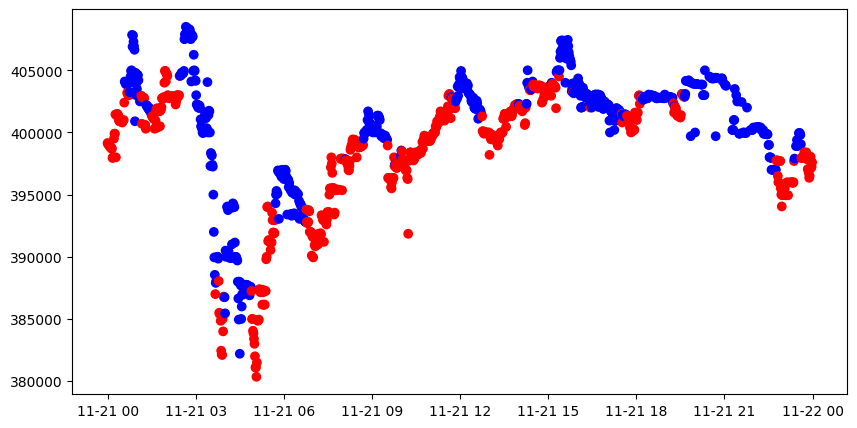

In [86]:
# label['bin']의 값을 시각화하여 추세 방향성을 빨간색(상승), 파란색(하락)으로 표시
# 이전의 모멘텀 방식 시각화와 달리, 통계 기반의 미래 레이블을 표현

sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

- label DataFrame 상위 20개 확인

In [87]:
# 추세 분석을 통해 생성한 label 테이블 상위 20개 확인
#  - 각 시점별로 t1, t_val, bin이 생성되어 있음을 확인

label.head(20)

,t1,t_val,bin
time,,,
2017-11-01 00:05:00,2017-11-01 06:10:00,-6.373987,-1
2017-11-01 00:12:00,2017-11-01 06:16:00,-6.273936,-1
2017-11-01 00:18:00,2017-11-01 06:23:00,-5.897474,-1
2017-11-01 00:24:00,2017-11-01 06:29:00,-5.425023,-1
2017-11-01 00:31:00,2017-11-01 06:35:00,-5.08177,-1
2017-11-01 00:37:00,2017-11-01 06:42:00,-4.895976,-1
2017-11-01 00:43:00,2017-11-01 06:48:00,-5.11334,-1
2017-11-01 00:50:00,2017-11-01 06:54:00,-4.866885,-1
2017-11-01 00:56:00,2017-11-01 07:00:00,-3.673143,-1


<br>

## 3. Feature Engineering

### 3.1 &nbsp;환경 구성 및 데이터 불러오기

- ta, shap 설치 및 관련 라이브러리 import

In [88]:
!pip install ta==0.9.0  # 기술적 분석 지표 생성 라이브러리 (ex. RSI, MACD, Bollinger 등)
!pip install shap       # 머신러닝 모델의 해석 가능성을 높여주는 라이브러리

In [89]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys

# 이거 두개는 LMS에서는 내부 파일이 존재함
# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.feature_importance import importance as imp

from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

<br>

- MDI 방식 피처 중요도 함수 정의

In [90]:
# 트리 기반 모델에서 사용되는 MDI(Mean Decrease Impurity) 기반 피처 중요도 평가 함수 정의
#  - impurity 감소량을 각 피처에 분산하여 평가
#  - 장점: 계산 빠름, 총합 1로 해석 쉬움
#  - 단점: 상호대체 가능한 변수들 간에 중요도 분산되는 경향 있음

"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

<br>

- 데이터 경로 설정 및 샘플 슬라이싱

In [91]:
# (이전 단계에서 생성한 ?) label 데이터를 저장한 .pkl 파일
# 원시 시계열 데이터를 저장한 .csv 파일 경로 준비

DATA_PATH = '.'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

In [92]:
# 데이터셋을 label이 존재하는 시점으로 슬라이싱

df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

- 원본 및 라벨 데이터 확인

In [93]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [94]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

- 클래스 분포 확인

In [95]:
# 각 클래스(상승/하락) 비율 확인

df_label_data.value_counts()

,count
t_value,
-1.0,306636
-0.0,302963
1.0,299289


<br>

### 3.2 &nbsp;Technical Index 적용

ta 라이브러리를 통해 기술적 분석 지표를 생성한다.

생성되는 주요 Feature:

Volume 기반

- Chaikin Money Flow (`volume_cmf`)
- Force Index (`volume_fi`)
- Money Flow Index (`volume_mfi`)
- Ease of Movement (`volume_sma_em`)
- Volume Price Trend (`volume_vpt`)

Volatility 기반

- Average True Range (ATR) (`volatility_atr`)
- Ulcer Index (`volatility_ui`)

Trend 기반

- MACD Diff (`trend_macd_diff`)
- ADX (Average Directional Movement Index) (`trend_adx`)

해당 feature들은 이후 머신러닝 모델의 입력 값(독립 변수)으로 사용된다. 이 지표들은 가격 추세, 거래량, 변동성 등을 수치적으로 표현하는 데 사용된다.

In [96]:
# 변수 설정 및 복사본 생성

mt = 1  # window multiplier (확장성 고려)
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [97]:
# 기술적 지표와 수익률 등 feature가 추가된 데이터프레임 전체 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


<br>

### 3.3 &nbsp;수익률/변동성 지표 적용

- 수익률 및 변동성 기반 파생 피처 생성
    - ret, std, vol_change 등

In [98]:
# 수익률(return) 및 변동성(std) 피처 추가

windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [99]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


<br>

### 3.4 &nbsp;피처 중요도 분석 및 선택

- X, y 분리 및 StandardScaler 정규화

In [100]:
# 피처(X)와 타겟(y) 분리
# 표준화(평균 0, 표준편차 1) 적용 → 스케일링은 SVM, 선형모델에서 중요

df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [101]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


In [102]:
X_sc.shape

(957, 23)

<br>

- 모델 학습

In [103]:
# RandomForest
#  - 클래스 불균형을 고려해 class_weight='balanced' 사용

rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

<br>

## 4. Feature Selection methods

### 4.1 &nbsp;MDI

- MDI(Mean Decrease Impurity) 기반 중요도 계산

In [104]:
# MDI(Mean Decrease Impurity) 방식으로 feature importance 측정
#  - 트리 기반 모델의 기본 중요도 계산 방식

feat_imp = mean_decrease_impurity(rfc, X.columns)

In [105]:
feat_imp

,mean,std
volume_cmf,0.045112,0.002038
volume_fi,0.043171,0.002667
volume_mfi,0.046790,0.002224
volume_sma_em,0.038617,0.002041
volume_vpt,0.027536,0.001627
volatility_atr,0.077725,0.003383
volatility_ui,0.047373,0.002487
trend_macd_diff,0.078876,0.003802
trend_adx,0.052752,0.002276
trend_trix,0.063270,0.003085


<br>

### 4.2 &nbsp;MDA

- Mean Decrease Accuracy
- SVC(RBF) 기반 MDA 계산

In [106]:
# MDA(Mean Decrease Accuracy) 방식 중요도 평가
#  → 특정 피처를 제거했을 때 성능 감소량으로 중요도 측정
# SVC(RBF) 모델 기반 교차검증 사용

svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)



- 피처 중요도 시각화

In [107]:
# MDI, MDA 두 방식으로 계산한 중요도를 시각화하여 비교
# ATR, MACD, ret_5 등 시장 변동성과 추세 관련 지표가 중요할 가능성

def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

- feat_imp와 feat_imp_mda 확인

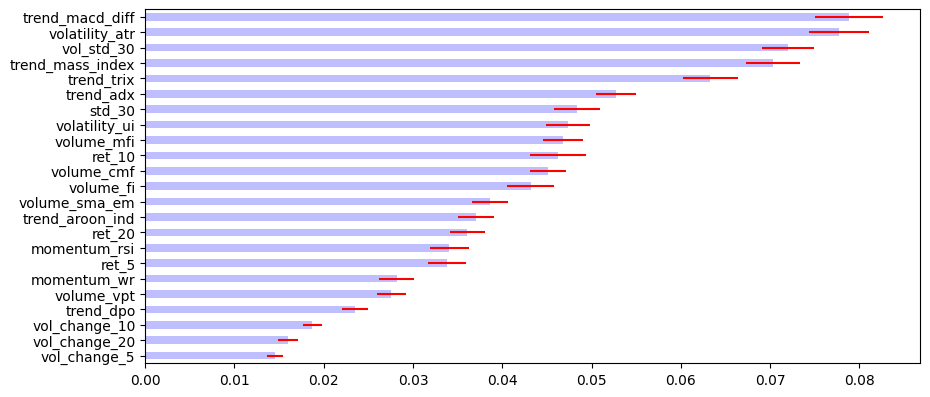

In [108]:
# volatility_atr : 시장의 변동성(진폭)을 측정하는 지표
# Average True Range (ATR)
plot_feature_importance(feat_imp)

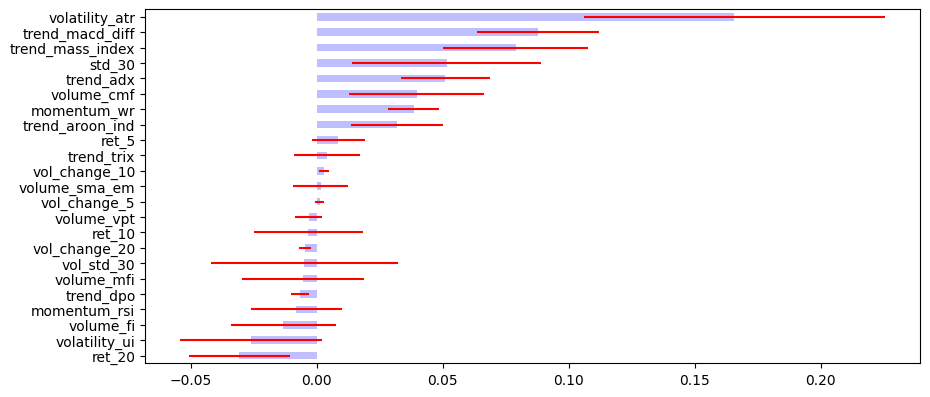

In [109]:
plot_feature_importance(feat_imp_mda)

<br>

### 4.3 &nbsp;RFE CV

- Recursive Feature Elimination
- RFECV로 최적 피처 자동 선택

In [110]:
# RFECV
#  - RFE + CV (Recursive Feature Elimination + Cross Validation)으로 최적 피처 자동 선택
#  - 최적의 피처 subset을 반복적으로 제거하면서 선택

svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [111]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [112]:
rfe_df[rfe_df['Optimal_Features']==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


<br>

### 4.4 &nbsp;SFS

- Sequential Feature Selection

In [113]:
# SFS (Sequential Forward Selection)으로 2개의 중요 피처 선택
# 선형 커널 SVC 기준으로 중요 피처 추출

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [114]:
# 선형 커널 SVC 기준으로 중요 피처 추출

sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=['Optimal_Features'])
sfs_df [sfs_df ['Optimal_Features']==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

<br>

### 4.5 &nbsp;SHAP

- Shapley Additive explanations
- 모델 해석을 위한 SHAP 분석

In [115]:
# shap 라이브러리를 통해 모델의 각 예측에 대해 특성별 기여도 분석 준비

import shap
# 모델 output을 raw로 바꿔주기
explainer = shap.TreeExplainer(rfc, model_output="raw")
shap_value = explainer.shap_values(X_sc)

In [116]:
# SHAP 분석 결과가 올바르게 생성되었는지 확인
#  - (샘플 수, 피처 수, 클래스 수) 형태
#  - 다중 클래스 분류 모델에서 각 클래스에 대해 SHAP 값이 계산된 것을 의미

shap_value.shape

(957, 23, 3)

- 클래스별 summary plot 시각화

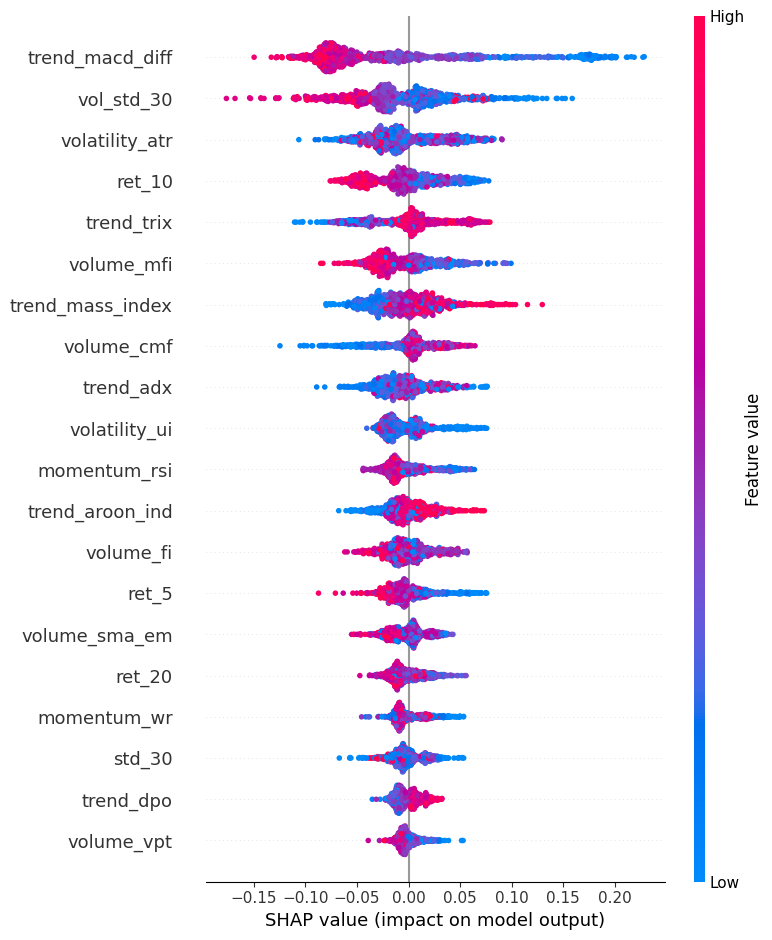

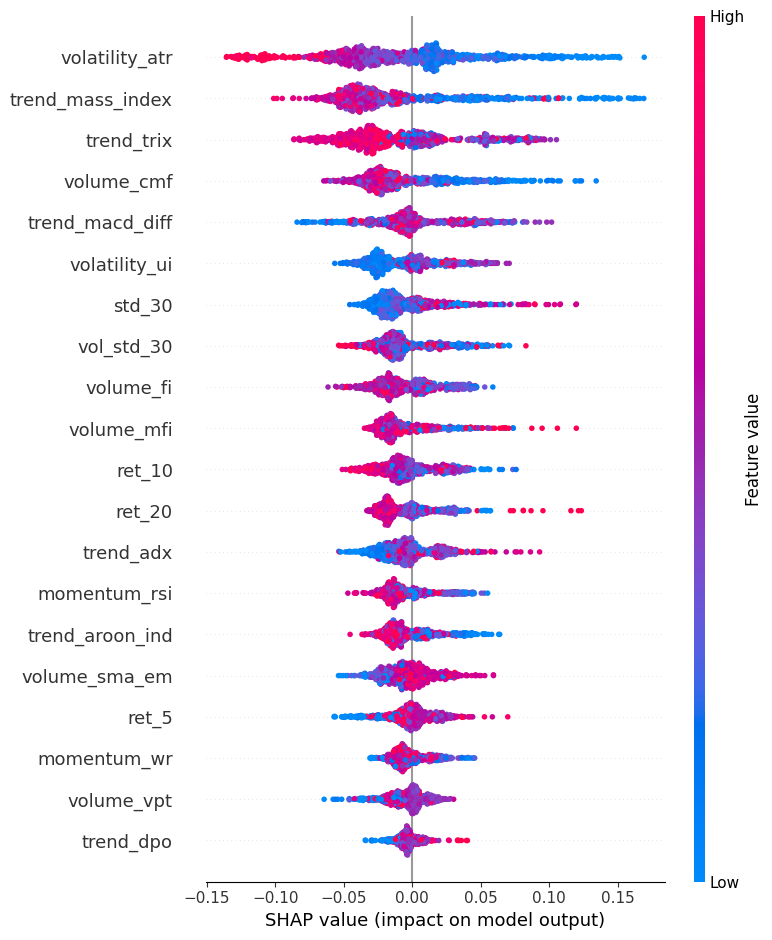

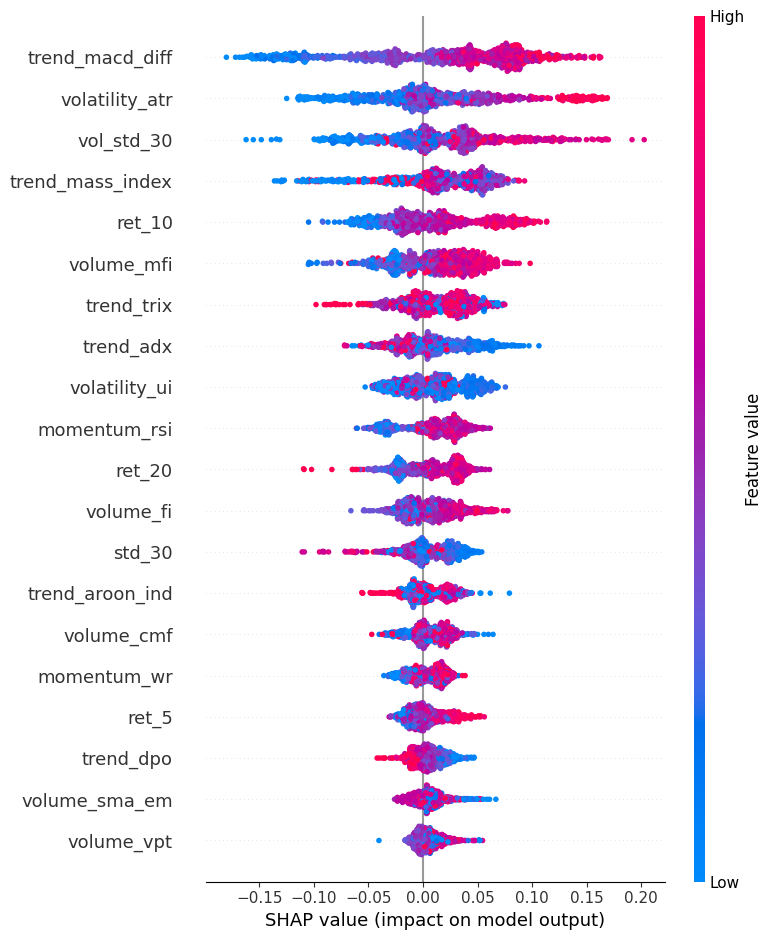

In [117]:
# 클래스 0, 1, 2에 대해 각각 SHAP summary plot을 시각화
#  - 다중 클래스 분류이므로 각 클래스별로 따로 시각화
#  - summary_plot(): feature별 중요도 분포 시각화
#  - X_sc: 정규화된 feature 데이터
# 각 클래스에 대해 어떤 피처가 의사결정에 가장 큰 영향을 주었는지 시각적으로 확인할 수 있다.

# 클래스 0
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

<br>

- 전체 피처 중요도 SHAP 평균 기준 정렬

In [120]:
# 절댓값 평균 기준으로 전체 feature 중요도 요약
#  - SHAP 값은 부호가 있는 값이므로 feature의 중요도를 평가할 때는 절댓값의 평균을 구하는 것이 일반적

mean_shap = np.mean(np.abs(shap_value), axis=(0, 2))  # 전체 샘플 및 클래스 기준 평균
shap_df = pd.Series(mean_shap, index=X_sc.columns).sort_values(ascending=False)
print(shap_df)  # SHAP 값 기준 피처 중요도 시리즈 (높은 순서대로 정렬)

trend_macd_diff     0.052390
volatility_atr      0.039495
trend_mass_index    0.034210
vol_std_30          0.032698
trend_trix          0.028205
ret_10              0.025968
volume_mfi          0.023827
volatility_ui       0.020824
volume_cmf          0.020270
trend_adx           0.019931
momentum_rsi        0.018201
volume_fi           0.017343
ret_20              0.017081
std_30              0.016374
trend_aroon_ind     0.015059
ret_5               0.012903
volume_sma_em       0.012249
momentum_wr         0.011715
trend_dpo           0.008966
volume_vpt          0.008683
vol_change_20       0.003869
vol_change_10       0.003773
vol_change_5        0.003116
dtype: float64


<br>

## 5. 학습 데이터 저장 및 유틸리티 모듈 구성

- 최종 feature + label 포함된 데이터 저장 (.pkl)

In [119]:
# 전처리 및 라벨링이 완료된 데이터를 파일로 저장
#  - SHAP 분석 등에서 사용한 최종 feature+label 데이터프레임을 .pkl 형식으로 저장

output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

<br>

- 모델링을 위한 전체 import 모듈 정리

In [121]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta  # 기술적 지표를 계산하기 위한 technical analysis 패키지

# 분류 모델, 교차검증, 평가 지표
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

- ml_get_train_times1, PKFold 클래스 정의 (정보 누수 방지용)

In [122]:
# PKFold 클래스 정의
# PKFold (Purged KFold) 교차검증을 위한 사용자 정의 클래스
#  - 금융 시계열 데이터에서는 샘플 간 시간적 의존성이 크므로 일반적인 KFold보다 정보 누수 방지가 중요한데
#  - 이를 위해 train set에서 test set의 레이블 추론에 관여할 수 있는 부분을 제거(purge)

"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

<br>
<br>

## 6. 모델 학습 및 평가

### 6.1 &nbsp;데이터 로드 및 준비

- .pkl 데이터 불러오기

In [123]:
# 전처리된 이더리움(ETH) 분당 데이터의 피처 및 라벨 파일을 불러오기 위한 경로 지정

DATA_PATH = '.'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

- t_value 이진화

In [124]:
# 데이터를 불러오고 t_value 라벨을 이진 분류(0 또는 1) 형태로 정제
#  - t_value == 1이면 그대로 1
#  - 나머지 값은 모두 0으로 변환
#  => binary classification으로 단순화

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

- 클래스 비율 확인

In [125]:
# 클래스 불균형 확인

df_data['t_value'].value_counts()

,count
t_value,
1.0,481
0.0,476


<br>

### 6.2 &nbsp;데이터 분할 및 정규화

- train/test 비율 설정 (70/20)

In [226]:
# 전체 데이터를 train/test로 나누기 위한 비율 설정
#  - train: 70%
#  - test: 20%
#  - validation: 10%

train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

- X, y 분리 및 정규화

In [227]:
# X: 피처 데이터 (5번째 열부터 마지막 전 열까지)
# y: 타겟 라벨 (t_value)
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# StandardScaler: 각 피처를 평균 0, 표준편차 1로 정규화 → 머신러닝 모델 학습에 유리
sc = StandardScaler()
X_sc = sc.fit_transform(X)

- train/test 셋 구성 및 학습용 1000개로 제한

In [228]:
# 전처리된 데이터를 train/test로 분할
#  - train_x만 1000개로 제한하여 실험 속도 향상

train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져온다.
train_x = train_x[:1000]
train_y = train_y[:1000]

<br>

### 6.3 &nbsp;교차검증 설정

- PKFold 적용 (n_cv=4)

In [291]:
# PKFold: 시간의 흐름을 고려하는 Purged K-Fold Cross Validation 사용
#  - 시계열 데이터는 시간 순서가 중요하기 때문에 일반 KFold보다 PKFold가 적합
#  - t1: 인덱스를 기준으로 시간 정보를 넘김

n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_cv, t1, 0)  # purged K-Fold

- 파라미터 cv 변경 실험
    - 모델: BaggingClassifier

In [290]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

n_cv_list = [3, 4, 5]
results = []

for n_cv in n_cv_list:
    print(f'\nn_cv = {n_cv}')

    # PKFold 객체 생성
    t1 = pd.Series(train_y.index.values, index=train_y.index)
    cv = PKFold(n_cv, t1, 0)  # purged K-Fold

    model = BaggingClassifier(random_state=42)
    acc_list, prec_list, recall_list, auc_list = [], [], [], []

    # 교차검증 루프
    for train_idx, test_idx in cv.split(train_x):
        X_tr, X_val = train_x[train_idx], train_x[test_idx]
        y_tr, y_val = train_y[train_idx], train_y[test_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        probs = model.predict_proba(X_val)[:, 1]

        acc_list.append(accuracy_score(y_val, preds))
        prec_list.append(precision_score(y_val, preds))
        recall_list.append(recall_score(y_val, preds))
        auc_list.append(roc_auc_score(y_val, probs))

    avg_result = {
        'n_cv': n_cv,
        'Accuracy': np.mean(acc_list),
        'Precision': np.mean(prec_list),
        'Recall': np.mean(recall_list),
        'AUC': np.mean(auc_list)
    }
    results.append(avg_result)

    print(f'Accuracy: {avg_result["Accuracy"]:.4f}')
    print(f'Precision: {avg_result["Precision"]:.4f}')
    print(f'Recall: {avg_result["Recall"]:.4f}')
    print(f'AUC: {avg_result["AUC"]:.4f}')



n_cv = 3
Accuracy: 0.5671
Precision: 0.6572
Recall: 0.5817
AUC: 0.6591

n_cv = 4
Accuracy: 0.6196
Precision: 0.7018
Recall: 0.6364
AUC: 0.6843

n_cv = 5
Accuracy: 0.5672
Precision: 0.6651
Recall: 0.6360
AUC: 0.6843


시계열 기반 모델 평가에서 Fold 개수가 모델 성능에 영향을 미친다는 점을 확인할 수 있다.

- 실험 결과를 비교해 보면 n_cv = 4에서 정확도가 0.6196으로, 가장 안정적이고 성능이 좋은 설정으로 보인다.

이후 모델 실험 시 n_splits 4를 기본값으로 사용하는 것이 합리적이라 판단된다.

<br>

### 6.4 &nbsp;베이스라인 학습 및 하이퍼파라미터 튜닝

Bagging + RandomForest 조합 모델을 GridSearchCV로 하이퍼파라미터 튜닝

In [130]:
# GirdSearchCV 하이퍼파라미터 튜닝: Bagging + RandomForest
#  - estimator__ 접두사: BaggingClassifier 내부의 base_estimator를 지정할 때 사용
#  - class_weight='balanced': 클래스 불균형 대비

bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_  # 최종적으로 성능이 가장 좋은 모델

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


<br>

### 6.5 &nbsp;최종 학습 및 예측

- best estimator로 전체 학습 데이터 재학습

In [181]:
# best estimator를 다시 전체 학습 데이터에 학습

gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=5,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.7, n_estimators=5)

<br>

- 예측 수행
    - predict, predict_proba 수행

In [182]:
# 테스트 데이터에 대해 예측 수행
#  - pred_y: 최종 예측 클래스 (0 또는 1)
#  - prob_y: 각 클래스에 대한 예측 확률

pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

<br>

- 성능 평가 지표 출력
    - confusion matrix, accuracy, precision, recall 출력

In [183]:
# 혼동 행렬과 주요 분류 지표 출력
#  - 정확도(Accuracy): 전체 맞춘 비율
#  - 정밀도(Precision): 양성 예측 중 실제 양성 비율
#  - 재현율(Recall): 실제 양성 중 모델이 맞춘 비율

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[86 50]
 [ 9 46]]
정확도:0.6910994764397905, 정밀도:0.4791666666666667, 재현율:0.8363636363636363


<br>

- ROC Curve 시각화 및 AUC 출력

auc:0.7343582887700535


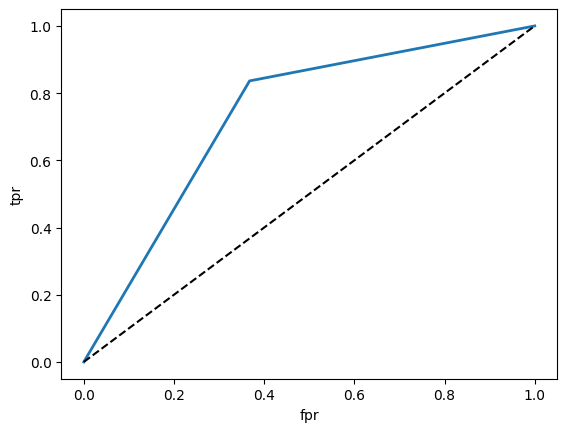

In [184]:
# ROC Curve 및 AUC (Area Under Curve) 계산
#  - AUC는 분류 모델의 전체 성능을 종합적으로 보여주는 지표로 1에 가까울수록 우수

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

<br>
<br>

### 6.6 &nbsp;추가 모델 학습 및 성능 비교

- 개별 모델 평가 함수 정의

In [138]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [231]:
def get_fit_params_with_early_stopping(model, X_train, X_test, y_train, y_test):
    """
    GridSearchCV/RandomizedSearchCV의 fit() 호출 시 사용할 fit_params 반환

    Parameters
    ----------
    model : 학습 대상 모델 객체
    X_train, X_test, y_train, y_test : 학습/평가 데이터

    Returns
    -------
    fit_params : dict
        모델 학습 시 fit()에 전달할 파라미터
    """

    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMClassifier):
        return {
            'eval_set': eval_set,
            'eval_metric': 'auc',
            'callbacks': [
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        }

    elif isinstance(model, XGBClassifier):
        return {
            'eval_set': eval_set,
            'verbose': False
        }

    else:
        # 일반 모델은 fit_params 없이 return
        return {}

In [249]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

def evaluate_single_model(model, model_name, X_test, y_test):
    """
    단일 모델(XGB, LGBM 등)의 예측 결과를 평가하는 함수

    Parameters
    ----------
    model : 학습된 모델 객체
    model_name : str, 모델 이름
    X_test : 테스트 입력 데이터
    y_test : 테스트 정답
    """
    # 예측 및 확률 추정
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # positive class 확률

    # 성능 지표 계산
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    # 출력
    print(f'\n{model_name} 평가 결과')
    print(cm)
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}')


- XGBoost 학습 및 평가

In [250]:
# 모델 정의
xgb_clf = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# 조기 종료 파라미터 구성
fit_params_xgb = get_fit_params_with_early_stopping(xgb_clf, train_x, test_x, train_y, test_y)

# 학습
xgb_clf.fit(train_x, train_y, **fit_params_xgb)

# 예측 및 평가
xgb_pred = xgb_clf.predict(test_x)
evaluate_single_model(xgb_clf, 'XGBoost', test_x, test_y)


XGBoost 평가 결과
[[66 70]
 [10 45]]
Accuracy: 0.5812, Precision: 0.3913, Recall: 0.8182, AUC: 0.7309


<br>

- LightGBM 학습 및 평가

In [251]:
# 모델 정의
lgbm_clf = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=64,
    min_child_samples=20,
    reg_alpha=0,
    reg_lambda=0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 조기 종료 파라미터 구성
fit_params_lgb = get_fit_params_with_early_stopping(lgbm_clf, train_x, test_x, train_y, test_y)

# 학습
lgbm_clf.fit(train_x, train_y, **fit_params_lgb)

# 예측 및 평가
lgbm_pred = lgbm_clf.predict(test_x)
evaluate_single_model(lgbm_clf, 'LightGBM', test_x, test_y)


LightGBM 평가 결과
[[81 55]
 [ 8 47]]
Accuracy: 0.6702, Precision: 0.4608, Recall: 0.8545, AUC: 0.7566


<br>

RandomForest, XGBoost, LightGBM을 적용해보았으나, 하이퍼파라미터 튜닝에도 불구하고 성능 상의 한계가 존재하는 것을 확인할 수 있다.

각 모델의 예측이 정확도(Accuracy)와 정밀도(Precision) 간의 균형을 맞추는 데 어려움을 보인다.

<br>

하나의 모델만으로는 복잡한 패턴을 충분히 반영하기 어렵다고 판단하여, 모델의 예측 결과를 통합해 성능을 향상시키기 위한 스태킹 앙상블 기법(Ensemble Stacking)을 도입한다.

<br>

- 최적의 Threshold 찾기

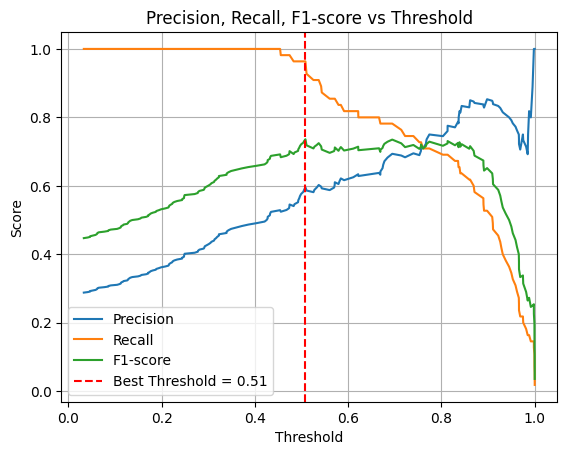

In [223]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# 확률 예측
stack_prob = stack_model.predict_proba(test_x)[:, 1]

# Threshold 조정
precisions, recalls, thresholds = precision_recall_curve(test_y, stack_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# 그래프 시각화
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [262]:
# 최적 threshold로 예측값 조정
stack_pred_adjusted = (stack_prob >= best_threshold).astype(int)

<br>

- Ensemble Stacking

In [276]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# (1) Base 모델 정의
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.03, max_depth=3,
                          use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=64, random_state=42))
]

# (2) 메타 모델: LogisticRegression
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# (3) 스태킹 모델
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    passthrough=True,  # 원래 feature도 전달
    n_jobs=-1
)

# (4) 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
train_x, test_x = X_scaled[:n_train], X_scaled[-n_test:]
train_y, test_y = y.iloc[:n_train], y.iloc[-n_test:]

# (5) 학습
stack_model.fit(train_x, train_y)

# (6) 예측 및 평가
stack_pred = stack_model.predict(test_x)
stack_prob = stack_model.predict_proba(test_x)[:, 1]

def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f'\n{name} 평가 결과')
    print(confusion_matrix(y_true, y_pred))
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}')

evaluate_model('Stacking (RF + XGB + LGBM → LogisticRegression)', test_y, stack_pred_adjusted, stack_prob)


Stacking (RF + XGB + LGBM → LogisticRegression) 평가 결과
[[100  36]
 [  2  53]]
Accuracy: 0.8010, Precision: 0.5955, Recall: 0.9636, AUC: 0.9118


<br>

Base 모델로는 RF, XGB, LGBM을, Meta 모델로는 Logistic Regression을 구성한 결과, Stacking 모델에서 정확도가 0.801로 유의미한 성능 향상을 보였다.

Confusion Matrix를 분석해 보면 양성 클래스(1)에 대한 재현율(Recall)이 매우 높고, 음성 클래스(0)에 대한 정밀도(Precision)는 비교적 낮은 편이라는 것을 알 수 있다.

<br>

ROC Curve로 해당 모델의 분류 정확도를 확인해 본다.





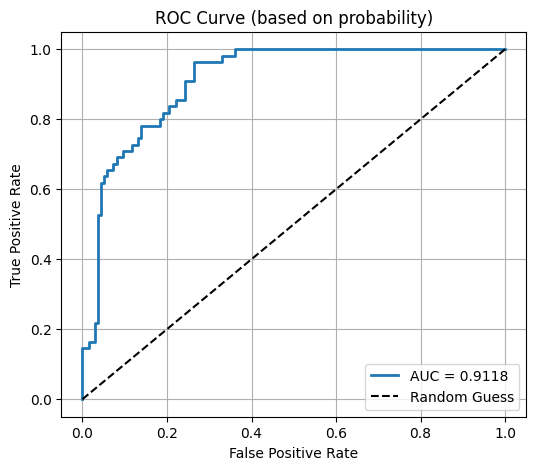

AUC: 0.9118


In [273]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 확률값으로 계산
stack_prob = stack_model.predict_proba(test_x)[:, 1]

# 확률 기반 ROC Curve
fpr, tpr, thresholds = roc_curve(test_y, stack_prob)
auc = roc_auc_score(test_y, stack_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (based on probability)')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC: {auc:.4f}")

AUC 0.9118로, 해당 모델이 91.2%의 분류 정확도를 가진다.

위험 탐지나 이상 감지 등 재현율 중심 문제에  적합한 성능을 보이는 모델이라고 판단할 수 있다.

<br>
<br>
<br>

## 7. 프로젝트 마무리

>이번 프로젝트는 암호화폐(ETH)의 분당 시계열 데이터를 바탕으로, 가격 변화의 패턴을 정량적으로 해석하고 이를 기반으로 추세를 예측하는 분류 모델을 개발하는 것까지 진행하였다.
>
>먼저, 종가 데이터를 활용해 모멘텀 신호, 국지적 극값 탐지, t-value 기반 회귀 라벨링 등 다양한 방식으로 시계열 기반의 추세 방향성을 정의하였다.
이러한 신호들을 바탕으로 라벨 데이터를 구축한 후, 기술적 분석 지표와 수익률·변동성 중심의 파생 피처들을 생성하여 학습 데이터를 정제하였다.
>
>모델링 단계에서는 RandomForest, XGBoost, LightGBM 등 개별 모델과 앙상블 기반의 StackingClassifier를 구성하여 분류 성능을 비교하였다.
>
>그 결과, StackingClassifier(RF + XGB + LGBM → LogisticRegression)가 Accuracy 0.8010, Recall 0.9636, AUC 0.9118로 전반적인 성능이 가장 우수한 것을 확인하였다.
>
>그 과정에서 SHAP 기반 피처 중요도 해석, Precision-Recall Curve 기반의 F1 최적 임계값 조정, ROC Curve 시각화 과정이 모델 해석과 성능 개선에 있어 중요하게 작용했다는 것을 알 수 있었다.
>
>이 프로젝트를 통해 시계열 분류 문제에 대한 데이터 처리, 라벨 정의, 모델링 전략, 최적화 기법, 성능 평가 및 해석까지의 프로세스를 구조화해 보고, 직접 구현해 보는 의미있는 경험이 되었다.